# Introduction to Machine Learning
## Lecture 2 - Classification
### Notebook 5: Decision Tree Classifier 
Prapared by: Said Bolluk

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Impurity Metrics in Decision Trees

In [2]:
probability_range = np.linspace(1e-4, 1, 100)

# 1) Cross-Entropy Loss
ce_list = list()
for p in probability_range:
    ce = -( 1*np.log(p) )
    ce_list.append(ce)
    

# 2) Gini Index
gini_list = list()
for p in probability_range:
    gini = 1 - ( p**2 + (1-p)**2 )
    gini_list.append(gini)


# 3) Misclassification Error
error_list = list()
for p in probability_range:
    x, y = p, (1-p)
    error = 1 - max(x, y)
    error_list.append(error)

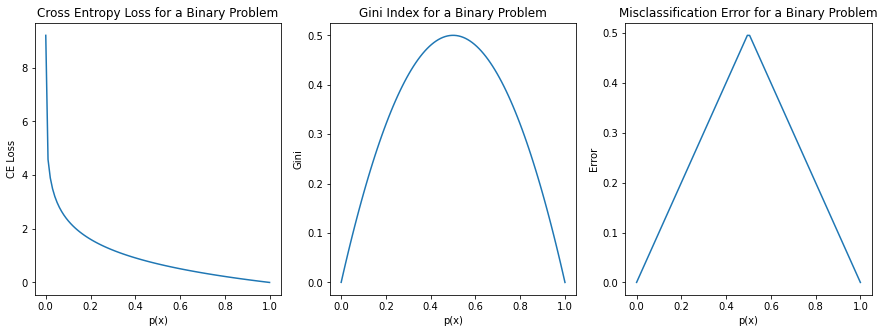

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# 1) CE Loss
ax1.plot(probability_range, ce_list)
ax1.set_title("Cross Entropy Loss for a Binary Problem")
ax1.set_xlabel("p(x)")
ax1.set_ylabel("CE Loss")
# 2) Gini Index
ax2.plot(probability_range, gini_list)
ax2.set_title("Gini Index for a Binary Problem")
ax2.set_xlabel("p(x)")
ax2.set_ylabel("Gini")
# 3) Misclassification Error
ax3.plot(probability_range, error_list)
ax3.set_title("Misclassification Error for a Binary Problem")
ax3.set_xlabel("p(x)")
ax3.set_ylabel("Error")
plt.show()

# DECISION TREE CLASSIFIER

## Data Preparation

In [4]:
data = pd.read_csv("../datasets/diabetes.csv")
data.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [5]:
# Create a copy of the dataset
diabetes_data = data.copy()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


There is no missing value. We can continue.

In [7]:
target_name = "Diabetic"
target = data[target_name]

data = data.drop(columns=[target_name])

Check the class distribution of the target

In [8]:
target.value_counts()

0    10000
1     5000
Name: Diabetic, dtype: int64

Dataset is slightly imbalanced. We can discard some of the instances from class zero (0) to equalize the value counts. However, total number of samples is highly sufficient to train the model properly. Therefore, we will perform classification first with the existing dataset and then handle imbalanced data if necessary.

### Feature Selection

Discard the **PatientID** column since it does not provide our estimator with any prior information.

In [9]:
redundant = ["PatientID"]
data = data.drop(columns=redundant)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pregnancies             15000 non-null  int64  
 1   PlasmaGlucose           15000 non-null  int64  
 2   DiastolicBloodPressure  15000 non-null  int64  
 3   TricepsThickness        15000 non-null  int64  
 4   SerumInsulin            15000 non-null  int64  
 5   BMI                     15000 non-null  float64
 6   DiabetesPedigree        15000 non-null  float64
 7   Age                     15000 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 937.6 KB


All the features are numerical. Let us observe the univariate feature distribution with histogram plots.

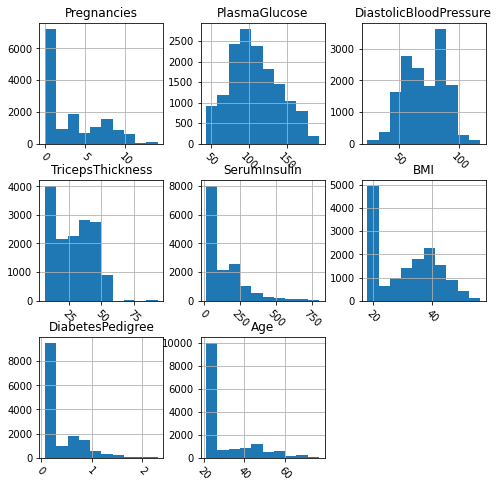

In [11]:
# Histogram view for the numerical features
data.hist(bins=10, figsize=(8, 8), xrot=-45)
plt.show()

There are some features with distributions differ from Gaussian Distribution. These are **Pregnacies, DiabetesPedigree, and Age.** However, it would not be wise to delete these features since they most likely include important information about the diabetes condition of a person. Therefore, we will continue with them.

### Preprocessing

Let us transform numerical features using StandardScaler.

In [12]:
# Check the number of data points
n_rows = data.shape[0]
print("Number of rows:", n_rows)

Number of rows: 15000


In [13]:
# Check the class distributions of the target
target.value_counts()

0    10000
1     5000
Name: Diabetic, dtype: int64

We have three classes: Not Diabetes (0), and Diabetes (1).

In [14]:
# First, split data into training and test sets

X = data.values
y = target.values

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    shuffle=True, random_state=42)

print("Training size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Training size: 10500
Test size: 4500


In [15]:
np.bincount(y_test)

array([3005, 1495], dtype=int64)

In [16]:
# Scale the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit the data according to the training set
scaler.fit(X_train)
# Transform the sets using training parameters
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Non-Parametric Classification: Decision Tree Classifier 

In [17]:
from sklearn.tree import DecisionTreeClassifier

We will analyze the performance of Decision Tree classifier with with different depths. This way, we can observe the relationship between the model's complexity and generalization performance.

In [18]:
# Set several maximum depths:
maximum_depth = [2**n for n in range(0, 6)]


accuracy_train = list()
accuracy_test = list()

for n in maximum_depth:
    # Define a model
    tree = DecisionTreeClassifier(max_depth=n, random_state=42)
    # Fit the training set
    tree.fit(X_train_scaled, y_train)
    # Make predictions over the test set
    train_predictions = tree.predict(X_train_scaled)
    test_predictions = tree.predict(X_test_scaled)
    # Calculate the accuracy score
    train_accuracy = np.sum(y_train==train_predictions) / y_train.shape[0]
    test_accuracy = np.sum(y_test==test_predictions) / y_test.shape[0]
    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)
    print(f"Test accuracy score of the Decision three with max_depth={n}: {test_accuracy:.3f}")

Test accuracy score of the Decision three with max_depth=1: 0.774
Test accuracy score of the Decision three with max_depth=2: 0.858
Test accuracy score of the Decision three with max_depth=4: 0.887
Test accuracy score of the Decision three with max_depth=8: 0.905
Test accuracy score of the Decision three with max_depth=16: 0.890
Test accuracy score of the Decision three with max_depth=32: 0.889


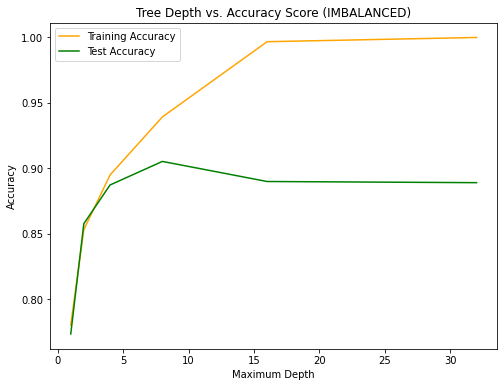

In [19]:
# Visualize the results
plt.figure(figsize=(8, 6))
plt.plot(maximum_depth, accuracy_train, color="orange", label="Training Accuracy")
plt.plot(maximum_depth, accuracy_test, color="green", label="Test Accuracy")
plt.title("Tree Depth vs. Accuracy Score (IMBALANCED)")
plt.legend()
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.show()

We can see that the model almost has a steady test accuracy score fixed at around 89%. Increasing the maximum depth of the tree caused the model to overfit the training set. Therefore, we did not record any improvements in the test accuracy after some point while increasing tree depth. Also, recall that the target is imbalanced. Let us now try to handle the imbalanced data to see if we can record any improvement in the model's prediction capacity.

### Handling Imbalanced Data

Making predictions is a lot more than just finding values. For example, in our case, the model predicts whether or not a person has diabetes. This is crucial since the results might enormously affect the person's life. For example, predicting that the person does not have diabetes (0) where the person has diabetes (1). This is far more costly than predicting diabetes (1) for a person who does not have diabetes (0). This is called the cost-sensitivity concept in machine learning. Also, remember that our dataset is imbalanced with fewer value counts for people with diabetes. This means that our model might be costly in predicting diabetes conditions as it prone to give not-diabetic (0) results.
\
\
There are several ways to handle imbalanced data. Considering that our model is also probably costly in making predictions, we can edit its decision mechanism. To do that, we should use the predicted probabilities instead of the predicted labels. Recall that machine learning models use probability to make predictions. If the estimated probability of a class is higher than the other class or 0.5, the model labels the instance with that class. Here, those probabilities should be used to manipulate the decision procedure of the model. For example, let us say that labeling a person diabetic is less costly than not-diabetic. Then, instead of setting a 0.5 threshold, we can express that our model predicts not-diabetic if the occurrence probability is higher than 0.6 for the negative class (not-diabetic). This way, our model will be inclined to make positive (diabetic) predictions, and we can reduce the cost. The decision threshold might vary and should be determined with elaborative testing. Therefore, we will skip this part.
\
\
Instead, we will discard some instances with zero (0) labels to equalize the value counts of the target. 

In [20]:
target.value_counts()

0    10000
1     5000
Name: Diabetic, dtype: int64

To equalize the class distribution, we will delete 5, 000 instances with zero (0) label. This way, final dataset will have 10,000 instances in total with equal class distribution.

We will repeat the Data Preparation steps:

In [21]:
data = diabetes_data
data.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [22]:
data = data.drop(data.loc[data["Diabetic"]==0].sample(frac=0.5).index)

In [23]:
target_name = "Diabetic"
target = data[target_name]

data = data.drop(columns=[target_name])

In [24]:
target.value_counts()

0    5000
1    5000
Name: Diabetic, dtype: int64

In [25]:
# Split data into training and test sets

X = data.values
y = target.values

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    shuffle=True, random_state=42)

print("Training size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Training size: 7000
Test size: 3000


In [26]:
# Scale the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now, we can perform classification

In [27]:
# Set several maximum depths:
maximum_depth = [2**n for n in range(0, 10)]


accuracy_train = list()
accuracy_test = list()

for n in maximum_depth:
    # Define a model
    tree = DecisionTreeClassifier(max_depth=n, random_state=42)
    # Fit the training set
    tree.fit(X_train_scaled, y_train)
    # Make predictions over the test set
    train_predictions = tree.predict(X_train_scaled)
    test_predictions = tree.predict(X_test_scaled)
    # Calculate the accuracy score
    train_accuracy = np.sum(y_train==train_predictions) / y_train.shape[0]
    test_accuracy = np.sum(y_test==test_predictions) / y_test.shape[0]
    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)
    print(f"Test accuracy score of the Decision three with max_depth={n}: {test_accuracy:.3f}")

Test accuracy score of the Decision three with max_depth=1: 0.822
Test accuracy score of the Decision three with max_depth=2: 0.859
Test accuracy score of the Decision three with max_depth=4: 0.888
Test accuracy score of the Decision three with max_depth=8: 0.908
Test accuracy score of the Decision three with max_depth=16: 0.889
Test accuracy score of the Decision three with max_depth=32: 0.886
Test accuracy score of the Decision three with max_depth=64: 0.886
Test accuracy score of the Decision three with max_depth=128: 0.886
Test accuracy score of the Decision three with max_depth=256: 0.886
Test accuracy score of the Decision three with max_depth=512: 0.886


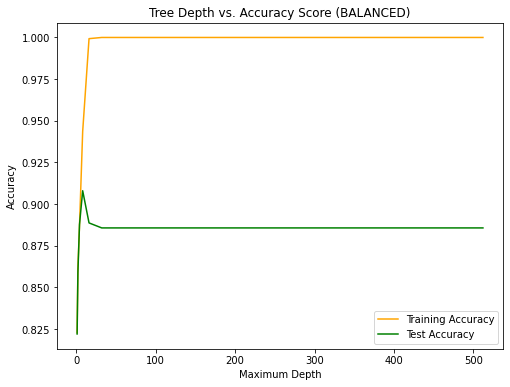

In [28]:
# Visualize the results
plt.figure(figsize=(8, 6))
plt.plot(maximum_depth, accuracy_train, color="orange", label="Training Accuracy")
plt.plot(maximum_depth, accuracy_test, color="green", label="Test Accuracy")
plt.title("Tree Depth vs. Accuracy Score (BALANCED)")
plt.legend()
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.show()

**Discussion:** We did not record any improvement after handling the imbalanced class distribution of the dataset. This is because the number of instances to train the model is sufficient for both classes. Plus, the feature distribution should be very distinct for the class zero (0), the non-diabetics, so that deleting zero rows does not affect the final results. This suggests that the available features can adequately represent the diabetic condition of a person and easily discriminate the classes without needing a high depth of trees.

# END